In [2]:
!pip install yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/7d/76/31fb9c58398f4cbdde4a0831d0407a1ca987fe828c7da9ce80969014a5a1/yfinance-0.2.40-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/6a/71/3656c00606e75e81f11721e6a1c973c3e03da8c7d8b665d20f78245384c6/frozendict-2.4.4-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.1 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a49515aabc2897

In [3]:
!pip install yfinance pandas numpy matplotlib scipy


[*********************100%%**********************]  5 of 5 completed


Missing data:
Series([], dtype: int64)
Annualized returns:
Ticker
AAPL     0.299015
GOOGL    0.235248
META     0.242660
NVDA     0.676507
TSLA     0.773575
dtype: float64

Annualized covariance matrix:
Ticker      AAPL     GOOGL      META      NVDA      TSLA
Ticker                                                  
AAPL    0.112682  0.077825  0.095371  0.121696  0.116779
GOOGL   0.077825  0.112449  0.106988  0.118459  0.097798
META    0.095371  0.106988  0.218838  0.143474  0.116340
NVDA    0.121696  0.118459  0.143474  0.294072  0.193164
TSLA    0.116779  0.097798  0.116340  0.193164  0.463820

Maximum Sharpe Ratio Portfolio:
Returns: 0.6779444550101478
Standard Deviation: 0.4992933372267317
Sharpe Ratio: 1.357807934661643

Minimum Volatility Portfolio:
Returns: 0.2725653574952152
Standard Deviation: 0.31618464635870247
Sharpe Ratio: 0.8620448862213176


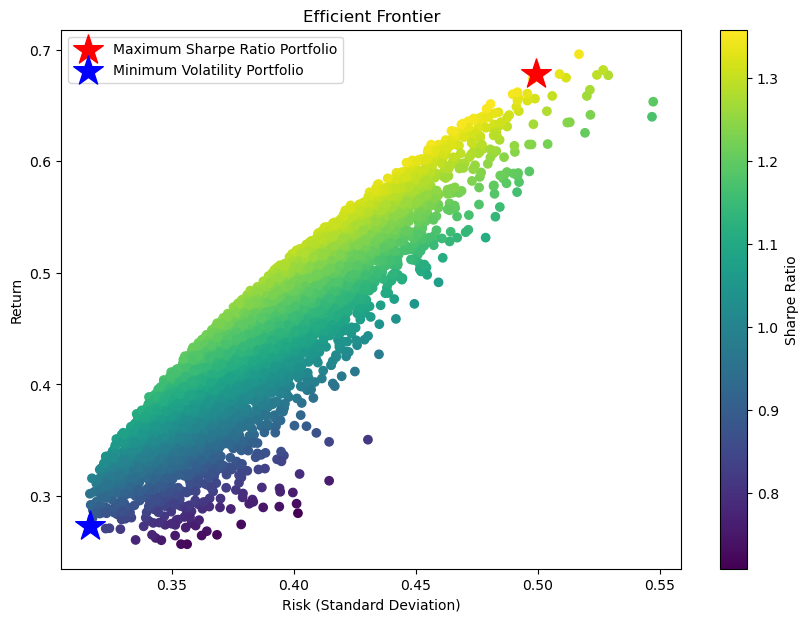


Optimal weights:
AAPL: 0.5067
NVDA: 0.4933
GOOGL: 0.0000
TSLA: 0.0000
META: 0.0000


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the list of stocks and the time range
tickers = ['AAPL', 'NVDA', 'GOOGL', 'TSLA', 'META']
start_date = '2020-01-01'
end_date = '2024-01-01'

# Get stock price data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Check for missing data and handle it
missing_data = data.isnull().sum()
print("Missing data:")
print(missing_data[missing_data > 0])

# Drop rows with missing data
data = data.dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate annualized returns and risk (standard deviation)
annualized_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

print("Annualized returns:")
print(annualized_returns)
print("\nAnnualized covariance matrix:")
print(annualized_cov_matrix)

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, annualized_returns, annualized_cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]  # Sharpe ratio

# Convert results to DataFrame
results_frame = pd.DataFrame(results.T, columns=['Returns', 'Std Dev', 'Sharpe Ratio'])

max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_frame.iloc[max_sharpe_idx]

min_vol_idx = results_frame['Std Dev'].idxmin()
min_vol_portfolio = results_frame.iloc[min_vol_idx]

print("\nMaximum Sharpe Ratio Portfolio:")
print("Returns:", max_sharpe_portfolio['Returns'])
print("Standard Deviation:", max_sharpe_portfolio['Std Dev'])
print("Sharpe Ratio:", max_sharpe_portfolio['Sharpe Ratio'])

print("\nMinimum Volatility Portfolio:")
print("Returns:", min_vol_portfolio['Returns'])
print("Standard Deviation:", min_vol_portfolio['Std Dev'])
print("Sharpe Ratio:", min_vol_portfolio['Sharpe Ratio'])

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results_frame['Std Dev'], results_frame['Returns'], c=results_frame['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.scatter(max_sharpe_portfolio['Std Dev'], max_sharpe_portfolio['Returns'], marker='*', color='r', s=500, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(min_vol_portfolio['Std Dev'], min_vol_portfolio['Returns'], marker='*', color='b', s=500, label='Minimum Volatility Portfolio')
plt.legend()
plt.title('Efficient Frontier')
plt.show()

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))

optimal_portfolio = minimize(minimize_volatility, len(tickers)*[1./len(tickers)], args=(mean_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal_portfolio['x']

print("\nOptimal weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")


[*********************100%%**********************]  6 of 6 completed


Missing data:
Series([], dtype: int64)
Annualized returns:
Ticker
AAPL     0.258011
GOOGL    0.144413
MCD      0.151040
META    -0.062620
NVDA     0.455077
TSLA     0.747064
dtype: float64

Annualized covariance matrix:
Ticker      AAPL     GOOGL       MCD      META      NVDA      TSLA
Ticker                                                            
AAPL    0.136407  0.093136  0.054364  0.113085  0.147414  0.138480
GOOGL   0.093136  0.119187  0.048753  0.117710  0.137818  0.112748
MCD     0.054364  0.048753  0.074391  0.051806  0.069882  0.070688
META    0.113085  0.117710  0.051806  0.237390  0.164167  0.130005
NVDA    0.147414  0.137818  0.069882  0.164167  0.313340  0.221768
TSLA    0.138480  0.112748  0.070688  0.130005  0.221768  0.521113

Maximum Sharpe Ratio Portfolio:
Returns: 0.48081112447747726
Standard Deviation: 0.4510331745324813
Sharpe Ratio: 1.066021640150666

Minimum Volatility Portfolio:
Returns: 0.18659163890822508
Standard Deviation: 0.26563019824883355
Sharpe Rati

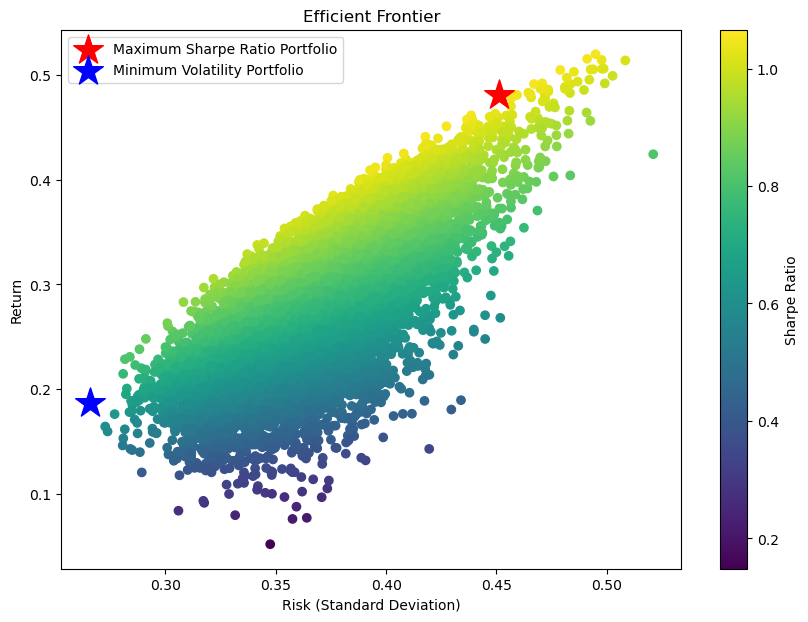


Optimal weights:
AAPL: 0.0725
NVDA: 0.2034
GOOGL: 0.7241
TSLA: 0.0000
META: 0.0000
MCD: 0.0000


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the list of stocks and the time range
tickers = ['AAPL', 'NVDA', 'GOOGL', 'TSLA', 'META','MCD']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Get stock price data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Check for missing data and handle it
missing_data = data.isnull().sum()
print("Missing data:")
print(missing_data[missing_data > 0])

# Drop rows with missing data
data = data.dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate annualized returns and risk (standard deviation)
annualized_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

print("Annualized returns:")
print(annualized_returns)
print("\nAnnualized covariance matrix:")
print(annualized_cov_matrix)

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Generate random portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, annualized_returns, annualized_cov_matrix)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]  # Sharpe ratio

# Convert results to DataFrame
results_frame = pd.DataFrame(results.T, columns=['Returns', 'Std Dev', 'Sharpe Ratio'])

max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_frame.iloc[max_sharpe_idx]

min_vol_idx = results_frame['Std Dev'].idxmin()
min_vol_portfolio = results_frame.iloc[min_vol_idx]

print("\nMaximum Sharpe Ratio Portfolio:")
print("Returns:", max_sharpe_portfolio['Returns'])
print("Standard Deviation:", max_sharpe_portfolio['Std Dev'])
print("Sharpe Ratio:", max_sharpe_portfolio['Sharpe Ratio'])

print("\nMinimum Volatility Portfolio:")
print("Returns:", min_vol_portfolio['Returns'])
print("Standard Deviation:", min_vol_portfolio['Std Dev'])
print("Sharpe Ratio:", min_vol_portfolio['Sharpe Ratio'])

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results_frame['Std Dev'], results_frame['Returns'], c=results_frame['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.scatter(max_sharpe_portfolio['Std Dev'], max_sharpe_portfolio['Returns'], marker='*', color='r', s=500, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(min_vol_portfolio['Std Dev'], min_vol_portfolio['Returns'], marker='*', color='b', s=500, label='Minimum Volatility Portfolio')
plt.legend()
plt.title('Efficient Frontier')
plt.show()

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))

optimal_portfolio = minimize(minimize_volatility, len(tickers)*[1./len(tickers)], args=(mean_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal_portfolio['x']

print("\nOptimal weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the list of stocks and the time range
tickers = ['AAPL', 'NVDA', 'GOOGL', 'TSLA', 'META']
tickers_new = ['AAPL', 'NVDA', 'GOOGL', 'TSLA', 'META', 'MCD']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Get stock price data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data_new = yf.download(tickers_new, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
returns_new = data_new.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

mean_returns_new = returns_new.mean()
cov_matrix_new = returns_new.cov()

# Calculate annualized returns and risk (standard deviation)
annualized_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

annualized_returns_new = mean_returns_new * 252
annualized_cov_matrix_new = cov_matrix_new * 252

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Define optimization constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))  # Set minimum weight to 0.01
bounds_new = tuple((0, 1) for asset in range(len(tickers_new)))  # Set minimum weight to 0.01

# Optimize original portfolio
optimal_portfolio = minimize(minimize_volatility, len(tickers)*[1./len(tickers)], args=(mean_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimal_portfolio['x']

# Optimize new portfolio with additional stock
optimal_portfolio_new = minimize(minimize_volatility, len(tickers_new)*[1./len(tickers_new)], args=(mean_returns_new, cov_matrix_new),
                                 method='SLSQP', bounds=bounds_new, constraints=constraints)
optimal_weights_new = optimal_portfolio_new['x']

# Print weights for original portfolio
print("\nOptimal Weights (Original Portfolio):")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.4f}")

# Print weights for new portfolio with additional stock
print("\nOptimal Weights (New Portfolio with Additional Stock):")
for i, ticker in enumerate(tickers_new):
    print(f"{ticker}: {optimal_weights_new[i]:.4f}")


[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  6 of 6 completed


Optimal Weights (Original Portfolio):
AAPL: 0.4511
NVDA: 0.5489
GOOGL: 0.0000
TSLA: 0.0000
META: 0.0000

Optimal Weights (New Portfolio with Additional Stock):
AAPL: 0.0725
NVDA: 0.2034
GOOGL: 0.7241
TSLA: 0.0000
META: 0.0000
MCD: 0.0000
